# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## **Task1 Importing Skin Cancer Data**
<b>Todo:</b> Take necessary actions to read the data

### **Importing all the important libraries**

In [1]:
import pathlib
import os
import PIL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

You are expected to load the data in the Colab environment by mounting the Google Drive. This will allow you to access the files from Google drive through Colab. 

Steps:
1. Upload the dataset in your Google Drive in a separate folder. Avoid spaces in the name of the folder or the zip file.
2. Mount the Google Drive using the code given below.
3. Unzip the file to access images.
4. Check the path for the datasets - train and test.


Note: The code is commented for you to learn and then make edits to execute the command.

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
# Your GDrive Directory
#!ls /content/gdrive/MyDrive

In [4]:
# Unzipping the files
# To do: Update the folder name and file name
#!unzip /content/gdrive/My\ Drive/folder_name/zip_file_name

Check the path mentioned in the output: <b>Skin cancer ISIC The International Skin Imaging Collaboration</b>

Provide the path for train and test images using pathlib library.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
default_path = 'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset'

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(default_path+"\\train")
data_dir_test = pathlib.Path(default_path+"\\test")

Check whether the data has been extracted successfully.

In [7]:
# Train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


## **Task 2: Loading the images using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility. You can refer to the following [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to know more about the function. You can even refer to the additional notebooks on the page to check how the variables are defined.

<b>Todo</b>: Create training and validation dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Task 3: Visualize the data**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

<b>Todo</b>: Create a code to visualize one instance of all the nine classes present in the dataset

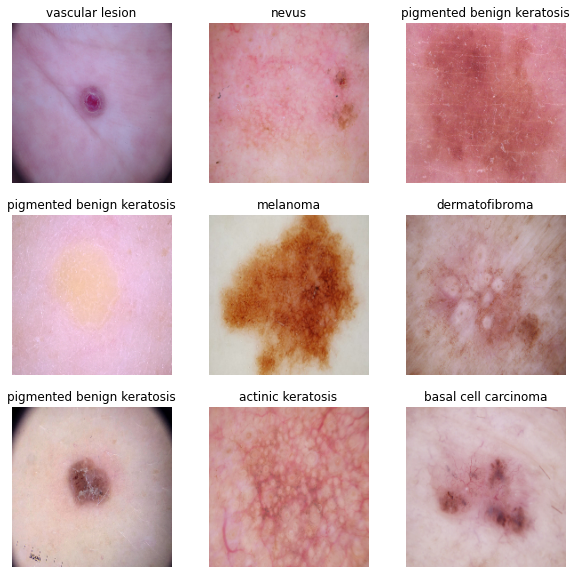

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## **Configure the dataset for performance**
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Task 4: Model Building & training**
<b>Todo</b>: Create a CNN model, which can accurately detect 9 classes present in the dataset. 


* Note: The RGB channel values are in the `[0, 255]` range. 
* This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]`.
* Use `layers.experimental.preprocessing.Rescaling` for this purpose.

### Rescaling the Data

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [15]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixel values are not from 0 to 1
print(np.min(first_image), np.max(first_image))

0.12516223 0.89673203


In [18]:
num_classes = len(class_names)

model_basic = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<b>Todo:</b> Compile the model<br>
Choose an appropirate optimiser and loss function for model training.

In [19]:
### Todo, choose an appropirate optimiser and loss function
model_basic.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

<b>Todo:</b> Train the model

In [21]:
%%time
epochs = 20
history_basic = model_basic.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 57s 998ms/step - loss: 2.0055 - accuracy: 0.2506 - val_loss: 1.7513 - val_accuracy: 0.3870
Epoch 2/20
56/56 [==============================] - 53s 947ms/step - loss: 1.6453 - accuracy: 0.4180 - val_loss: 1.4648 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 49s 870ms/step - loss: 1.4362 - accuracy: 0.4916 - val_loss: 1.4195 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 49s 882ms/step - loss: 1.3398 - accuracy: 0.5424 - val_loss: 1.3908 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 50s 886ms/step - loss: 1.2622 - accuracy: 0.5575 - val_loss: 1.5315 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 49s 872ms/step - loss: 1.2079 - accuracy: 0.5608 - val_loss: 1.3900 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 50s 893ms/step - loss: 1.1325 - accuracy: 0.6004 - val_loss: 1.3974 - val_accuracy: 0.5481

### **Visualizing training results**

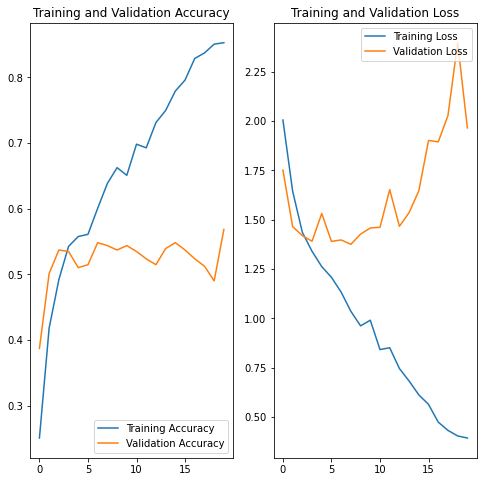

In [22]:
acc = history_basic.history['accuracy']
val_acc = history_basic.history['val_accuracy']

loss = history_basic.history['loss']
val_loss = history_basic.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [54]:
print("Training Accuracy:",history_basic.history['accuracy'][-1])
print("Validation Accuracy:",history_basic.history['val_accuracy'][-1])

Training Accuracy: 0.8526785969734192
Validation Accuracy: 0.5682326555252075


`Here the model overfits the data as the Training accuracy is 0.85 but the validation accuracy has dropped to 0.56, the drop being nearly 28%. Hence indicating that the model is overfit`

## **Task 5: Data augmentation**
Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


<b>Todo:</b> After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy

In [23]:
data_augmentation =  keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

In [24]:
help(train_ds.take)

Help on method take in module tensorflow.python.data.ops.dataset_ops:

take(count, name=None) method of tensorflow.python.data.ops.dataset_ops.PrefetchDataset instance
    Creates a `Dataset` with at most `count` elements from this dataset.
    
    >>> dataset = tf.data.Dataset.range(10)
    >>> dataset = dataset.take(3)
    >>> list(dataset.as_numpy_iterator())
    [0, 1, 2]
    
    Args:
      count: A `tf.int64` scalar `tf.Tensor`, representing the number of
        elements of this dataset that should be taken to form the new dataset.
        If `count` is -1, or if `count` is greater than the size of this
        dataset, the new dataset will contain all elements of this dataset.
      name: (Optional.) A name for the tf.data operation.
    
    Returns:
      Dataset: A `Dataset`.



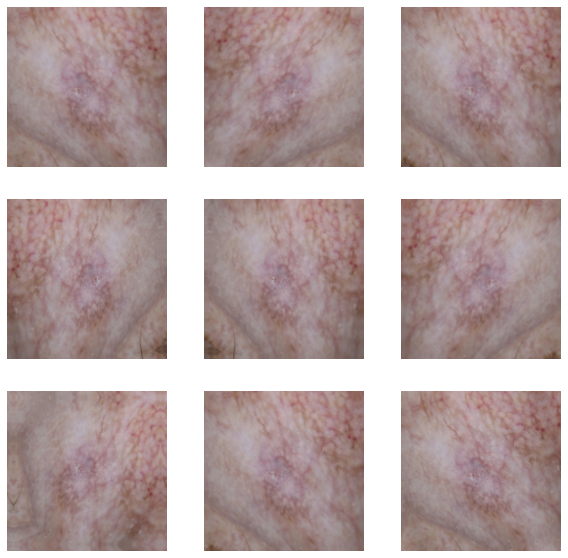

In [25]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Task 6: Create, compile and train the model**
<b>Todo:</b> Define the model with augmentation strategy defined earlier

In [26]:
model_augmented = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<b>Todo:</b> Compile the model

In [27]:
model_augmented.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_augmented.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

<b>Todo:</b> Train the model

In [28]:
%%time
epochs = 20
history_augmented = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 59s 1s/step - loss: 1.9974 - accuracy: 0.2746 - val_loss: 1.7760 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 59s 1s/step - loss: 1.6907 - accuracy: 0.3856 - val_loss: 1.6094 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 57s 1s/step - loss: 1.6005 - accuracy: 0.4448 - val_loss: 1.5736 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 1.4205 - accuracy: 0.5117 - val_loss: 1.4891 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 61s 1s/step - loss: 1.3732 - accuracy: 0.5112 - val_loss: 1.3790 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 61s 1s/step - loss: 1.3575 - accuracy: 0.5257 - val_loss: 1.3765 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 57s 1s/step - loss: 1.3051 - accuracy: 0.5419 - val_loss: 1.3137 - val_accuracy: 0.5414
Epoch 8/20
56/56 [==

### **Visualizing the results**

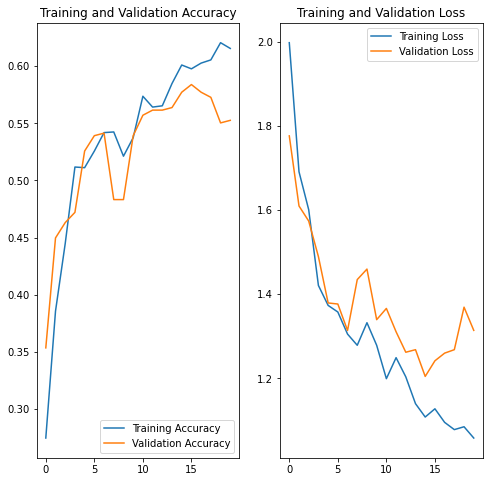

In [29]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']

loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [55]:
print("Training Accuracy:",history_augmented.history['accuracy'][-1])
print("Validation Accuracy:",history_augmented.history['val_accuracy'][-1])

Training Accuracy: 0.6155133843421936
Validation Accuracy: 0.5525727272033691


`Here the training accuracy has dropped to 0.61 but the validation accuracy has remained nearly the same at 0.55. So the difference between the accuracies is just 0.06 which is significantly better than 0.28. Hence the model has improved the previous overfit model after augmenting the model and adding dropout layers`

## **Task 7: Class distribution**

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.



<b>Todo:</b> Find the distribution of classes in the training dataset.**

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list))

2239


In [31]:
#create the dataframe containing all the path and their labels
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
1,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
2,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
3,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
4,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
...,...,...
2234,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
2235,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
2236,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
2237,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion


In [32]:
path_list[0]

'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset\\train\\actinic keratosis\\ISIC_0025780.jpg'

In [33]:
## Visualise the distribution of each labels from the dataframe
## Your code goes here.
import seaborn as sns

In [34]:
original_df["Label"].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

C:\Users\jibin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

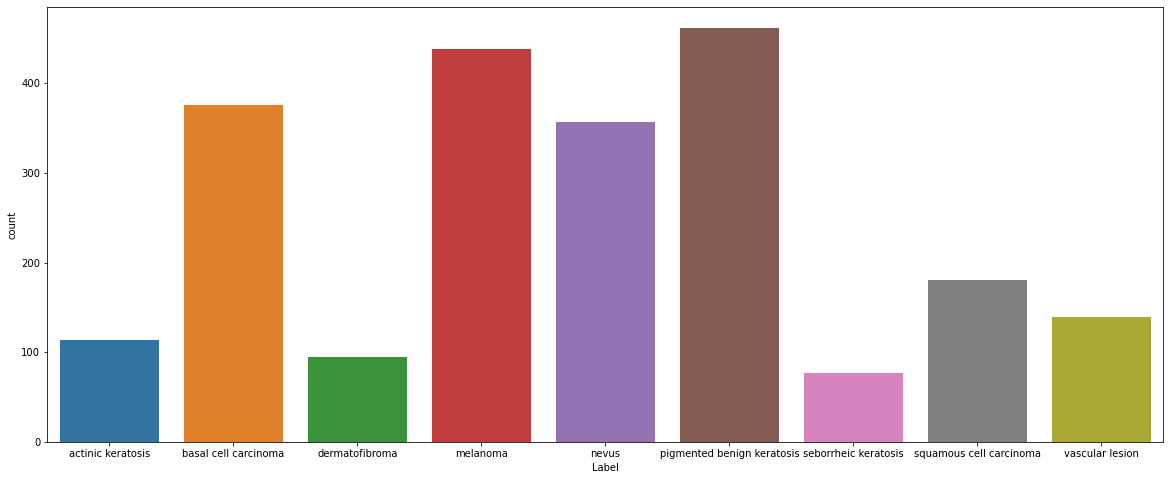

In [35]:
plt.figure(figsize=[20,8])
sns.countplot(original_df["Label"])

### **Questions:**  
 - Which class has the least number of samples?
 - Which classes dominate the data in terms proportionate number of samples?


- `seborrheic keratosis has the least number of samples with 77 number of samples`
- `'pigmented benign keratosis','pigmented benign keratosis','basal cell carcinoma' and 'nevus' dominate the data in terms of proportionate number of samples`

## **Task 8: Rectifying the class imbalance**
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.<br>
<b>Todo:</b> Apply augmentor

In [36]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset=default_path+"\\train"
print(os.path.exists(path_to_training_dataset))
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+"\\"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

True


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8E706D30>:   0%| | 1/500 [00:00<01:17,  6.46 Samples/s]

Initialised with 114 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28D8ECF4F10>: 100%|█| 500/500 [00:13<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28D8ED39940>: 100%|█| 500/500 [00:13<00:
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28D8ECEEA30>:   0%| | 1/500 [00:00<01:29

Initialised with 95 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8EA6FAC0>: 100%|█| 500/500 [00:13<00:00, 35.85 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x28D8ED54EB0>: 100%|█| 500/500 [01:03<00
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x28D8ED10DC0>: 100%|█| 500/500 [00:57<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8EA25DC0>: 100%|█| 500/500 [00:13<00:00, 36.38 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x28D8E9FDA90>: 100%|█| 500/500 [00:30<00
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8ED4DA00>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8ED54F70>: 100%|█| 500/500 [00:13<00:00, 36.81 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28D8E9FD9D0>:   0%| | 0/500 [00:00<?, ? 

Initialised with 139 image(s) found.
Output directory set to D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28D8ED5AE20>: 100%|█| 500/500 [00:13<00:00, 36.58 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_102d7361-4216-4d4a-916e-3cc1a757a3f1.jpg',
 'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_14ce4e85-bf31-4374-928e-5953e85618b0.jpg',
 'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_75ebd078-3065-431e-a57c-7698305df34b.jpg',
 'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.MelanomaAssignment\\dataset\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_841fa3a8-8c1c-42ab-8757-5efa6a0bf80f.jpg',
 'D:\\upGradAInML\\workspace\\8.DeepLearning\\2.ConvolutionalNeuralNetworks\\7.Melan

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [44]:
new_df

,Path,Label
0,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
1,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
2,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
3,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
4,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,actinic keratosis
...,...,...
4495,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
4496,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
4497,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion
4498,D:\upGradAInML\workspace\8.DeepLearning\2.Conv...,vascular lesion


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## **Task9: Model Building & training**
<b>Todo:</b> Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

<b>Todo:</b> Create a training dataset

In [46]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<b>Todo:</b> Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<b>Todo:</b> Create your model (make sure to include normalization)

In [48]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixel values are not from 0 to 1
print(np.min(first_image), np.max(first_image))

0.23088236 0.9950984


In [49]:
model_augmented_class_imbalance = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<b>Todo:</b> Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model_augmented_class_imbalance.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_augmented_class_imbalance.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

<b>Todo:</b>  Train your model

In [51]:
%%time
epochs = 50
history_augmented_class_imbalance = model_augmented_class_imbalance.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 192s 1s/step - loss: 2.2550 - accuracy: 0.1565 - val_loss: 2.3303 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 204s 1s/step - loss: 1.9939 - accuracy: 0.2400 - val_loss: 1.9928 - val_accuracy: 0.2665
Epoch 3/50
169/169 [==============================] - 193s 1s/step - loss: 1.7308 - accuracy: 0.3457 - val_loss: 1.5980 - val_accuracy: 0.4083
Epoch 4/50
169/169 [==============================] - 190s 1s/step - loss: 1.5671 - accuracy: 0.4026 - val_loss: 1.5635 - val_accuracy: 0.4202
Epoch 5/50
169/169 [==============================] - 259s 2s/step - loss: 1.5033 - accuracy: 0.4156 - val_loss: 1.4987 - val_accuracy: 0.4120
Epoch 6/50
169/169 [==============================] - 210s 1s/step - loss: 1.4514 - accuracy: 0.4403 - val_loss: 1.3696 - val_accuracy: 0.4618
Epoch 7/50
169/169 [==============================] - 277s 2s/step - loss: 1.3885 - accuracy: 0.4594 - val_loss: 1.3763 - val_accuracy: 0.4573

<b>Todo:</b>  Visualize the model results

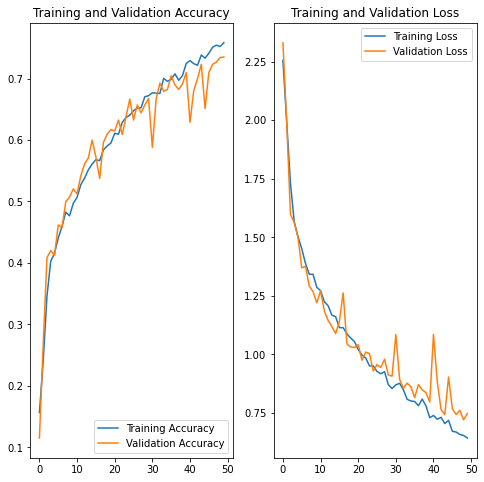

In [52]:
acc = history_augmented_class_imbalance.history['accuracy']
val_acc = history_augmented_class_imbalance.history['val_accuracy']

loss = history_augmented_class_imbalance.history['loss']
val_loss = history_augmented_class_imbalance.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Task 10: Analyzing the results**

### **Question:**
- Did you get rid of underfitting/overfitting from the model? 
- Did class rebalance help in the process?


In [56]:
print("Training Accuracy:",history_augmented_class_imbalance.history['accuracy'][-1])
print("Validation Accuracy:",history_augmented_class_imbalance.history['val_accuracy'][-1])

Training Accuracy: 0.7583457231521606
Validation Accuracy: 0.7349665760993958


- `Yes the overfitting from the model has been eliminated as we have a Training Accuracy of 0.75 and Validation Accuracy of 0.73 so just a difference of 0.02 so the model is perfectly fit and neither does the model overfit or underfit the data`
-`Yes class rebalance helped a lot in improving the validation accuracy of the model from 0.55 to 0.73, which is a signficant improvement from the previous model.`

## Testing the Model on Test Data

Lets predict with an image from our dataset

In [66]:
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [92]:
print(default_path)
prediction_url = default_path+"\\test\\melanoma\\ISIC_0000029.jpg"
print(prediction_url)
img = tf.keras.utils.load_img(
    prediction_url, target_size=(img_height, img_width)
)

D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset
D:\upGradAInML\workspace\8.DeepLearning\2.ConvolutionalNeuralNetworks\7.MelanomaAssignment\dataset\test\melanoma\ISIC_0000029.jpg


In [93]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_augmented_class_imbalance.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to melanoma with a 95.49 percent confidence.


## Conclusions

- We significantly improved the model by augmentation and handling class imbalance
- We have achieved an accuracy of 0.73